# A6 Convolutional Networks

Submission by: Dilochan Karki

# `ConvNet2D` to be changed to `ConvNet`

In [1]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

In [19]:
class ConvNet(torch.nn.Module):

    def __init__(self, input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device='cpu'):
        '''Example for MNIST:
        ConvNet2D((1, 28, 28), [(20, 3, 1), (10, 4, 2)], [20], 'tanh', 'cuda')
        '''

        super().__init__()

        self.input_shape = input_shape
        self.device = device
        print('ConvNet: Using device', self.device)
        self.activation_function = torch.nn.Tanh() if activation_function == 'tanh' else torch.nn.ReLU()

        # Create all convolutional layers
        n_in = input_shape[0]
        self.conv_layers = torch.nn.Sequential()
        if len(self.input_shape) == 3:
          for nh, patch_size, stride in conv_specs:
              self.conv_layers.append( torch.nn.Sequential( torch.nn.Conv2d(n_in, nh, patch_size, stride),
                                                            self.activation_function) )
              n_in = nh
        else:
          for nh, patch_size, stride in conv_specs:
              self.conv_layers.append( torch.nn.Sequential( torch.nn.Conv1d(n_in, nh, patch_size, stride),
                                                            self.activation_function) )
              n_in = nh

        # To determine the number of inputs to the first fully connected layer,
        # pass some zero input samples through the conv_layers and see how many values result
        z = self.conv_layers(torch.zeros([1] + list(input_shape)))
        z = z.reshape(1, -1)
        n_in = z.shape[1]

        # Create all fully connected layers.
        self.fc_layers = torch.nn.Sequential()
        for nh in fc_specs:
            self.fc_layers.append( torch.nn.Sequential( torch.nn.Linear(n_in, nh),
                                                        self.activation_function) )
            n_in = nh

        output_layer = torch.nn.Linear(n_in, n_outputs)
        self.fc_layers.append(output_layer)

        self.pc_trace = []
        self.best_pc_val = None
        self.to(self.device)

    def _forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Zs = [X]
        for conv_layer in self.conv_layers:
            Zs.append( conv_layer(Zs[-1]) )

        # Flatten outputs from last convolutional layer.
        Zs[-1] = Zs[-1].reshape(n_samples, -1)
        for fc_layer in self.fc_layers:
            Zs.append( fc_layer(Zs[-1]) )

        return Zs

    def forward(self, X, keep_all_outputs=False):
        if not isinstance(X, torch.Tensor):
            X = self._X_as_torch(X)
        Zs = self._forward_all_outputs(X)

        if keep_all_outputs:
            self.Zs = Zs

        return Zs[-1]

    def _X_as_torch(self, X):
        if isinstance(X, torch.Tensor):
            return X
        else:
            return torch.from_numpy(X.reshape([-1] + list(self.input_shape)).astype(np.float32)).to(self.device)

    def _T_as_torch(self, T):
        if isinstance(T, torch.Tensor):
            return T
        else:
            return torch.from_numpy(T.astype(np.int64)).to(self.device)

    def percent_correct(self, Yclasses, T):
        if isinstance(T, torch.Tensor):
            return (Yclasses == T).float().mean().item() * 100
        else:
            return (Yclasses == T).mean().item() * 100

    def train(self, Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size=-1, method='sgd', learning_rate=0.01, verbose=True):

        # Assuming Ttrain includes all possible class labels
        self.classes = np.unique(Ttrain)

        self.X_means = Xtrain.mean(0)
        self.X_stds = Xtrain.std(0)
        self.X_stds[self.X_stds == 0] = np.mean(self.X_stds)

        Xtrain = (Xtrain - self.X_means) / self.X_stds
        Xval = (Xval - self.X_means) / self.X_stds

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        loss_f = torch.nn.CrossEntropyLoss()

        if batch_size == -1:
            batch_size = Xtrain.shape[0]

        self.batch_size = batch_size  # remember this for use in forward functions

        for epoch in range(n_epochs):

            for first in range(0, Xtrain.shape[0], batch_size):
                Xtrain_batch = Xtrain[first:first + batch_size]
                Ttrain_batch = Ttrain[first:first + batch_size]

                # Set data matrices to torch.tensors if not already.
                Xtrain_batch = self._X_as_torch(Xtrain_batch)
                Ttrain_batch = self._T_as_torch(Ttrain_batch)

                Y = self(Xtrain_batch)
                loss = loss_f(Y, Ttrain_batch)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            with torch.no_grad():
                pc_train = self.percent_correct(self.use(Xtrain, standardized=True), Ttrain)
                pc_val = self.percent_correct(self.use(Xval, standardized=True), Tval)
                self.pc_trace.append([pc_train, pc_val])

                if self.best_pc_val is None or pc_val > self.best_pc_val:
                    self.best_pc_val = pc_val
                    self.best_epoch = epoch + 1
                    # Save weights to be restored when done training
                    self.best_parameters = [p.clone() for p in self.parameters()]

            if verbose and (epoch + 1) % max(1, (n_epochs // 10)) == 0:
                print(f'{method} Epoch {epoch + 1} % Correct: Train {self.pc_trace[-1][0]:.1f}'
                      f' Val {self.pc_trace[-1][1]:.1f}')

        # Restore weights that resulted in best_pc_val
        for p, bestp in zip(self.parameters(), self.best_parameters):
            p.data = bestp.clone()

        return self

    def _softmax(self, Y):
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X, standardized=False, return_probs=False, keep_all_outputs=False):

        if not standardized:
            X = (X - self.X_means) / self.X_stds

        classes = []
        probs = []
        return_numpy = False

        for first in range(0, X.shape[0], self.batch_size):
            X_batch = X[first:first + self.batch_size]

            if not isinstance(X_batch, torch.Tensor):
                X_batch = self._X_as_torch(X_batch)
                return_numpy = True

            with torch.no_grad():

                Y = self(X_batch, keep_all_outputs=keep_all_outputs)
                class_index = torch.argmax(Y, axis=1).cpu().numpy()
                classes.extend(self.classes[class_index])

                if return_probs:
                    probs.extend(self._softmax(Y).cpu().numpy())

        if return_numpy:
            classes = np.array(classes)
            probs = np.array(probs)

        if return_probs:
            return classes, probs
        else:
            return classes

The following code cell tests your code with the MNIST data set.

After you make the change of `ConvNet2D` to `ConvNet`, in the following code cell comment out the line that calls `ConvNet2D` and uncomment the line that calls `ConfNet`. You should see similar results running with either class.  You might need to modify some parameters, such as reducing `batch_size` if you run out of memory or your python kernel dies when running this.

In [87]:
import gzip
import pickle

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# device = 'cpu'

with gzip.open('mnist.pkl.gz', 'rb') as f:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1]
Xval = valid_set[0]
Tval = valid_set[1]
Xtest = test_set[0]
Ttest = test_set[1]

n_train = 5000
Xtrain = Xtrain[:n_train]
Ttrain = Ttrain[:n_train]
# Notice the use of :,d to format integers with comma separators.
print(f'Only using {n_train:,d} training samples to reduce computation time.')

conv_specs = [(40, 4, 1), (20, 3, 2), (20, 3, 2)]
conv_specs = []
fc_specs = [20]
fc_specs = []
input_shape = (1, 28, 28)
n_outputs = 10
n_epochs = 20
batch_size = 2000
method = 'adam'
learning_rate = 0.001

# nnet = ConvNet2D(input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device=device)
nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device=device)

nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')


Only using 5,000 training samples to reduce computation time.
ConvNet: Using device cuda
adam Epoch 2 % Correct: Train 59.5 Val 57.8
adam Epoch 4 % Correct: Train 73.6 Val 73.5
adam Epoch 6 % Correct: Train 78.0 Val 78.1
adam Epoch 8 % Correct: Train 81.4 Val 81.2
adam Epoch 10 % Correct: Train 84.1 Val 83.1
adam Epoch 12 % Correct: Train 86.1 Val 85.0
adam Epoch 14 % Correct: Train 87.6 Val 86.2
adam Epoch 16 % Correct: Train 88.5 Val 87.1
adam Epoch 18 % Correct: Train 89.4 Val 87.8
adam Epoch 20 % Correct: Train 89.8 Val 88.1
% Correct: Train 89.8 Val 88.1 Test 87.2


In [8]:
def confusion_matrix(Y_classes, T, class_names, background_cmap=None):
    class_T = np.arange(len(class_names))
    table = []
    for true_class in class_T:  #class_names:
        row = []
        for Y_class in class_T:  # class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    print('Percent Correct (Actual class in rows, Predicted class in columns)')
    if background_cmap:
        return conf_matrix.style.background_gradient(cmap=background_cmap, axis=1).format('{:.1f}')
    else:
        return conf_matrix

In [21]:
confusion_matrix(nnet.use(Xtest), Ttest, range(10), 'Blues')

Percent Correct (Actual class in rows, Predicted class in columns)


,0,1,2,3,4,5,6,7,8,9
0,93.2,0.1,0.2,0.3,0.2,2.9,1.7,0.5,0.6,0.3
1,0.0,96.2,0.4,0.6,0.2,0.5,0.4,0.0,1.7,0.0
2,1.7,2.6,81.7,2.6,1.0,0.1,2.4,1.9,5.7,0.2
3,0.3,1.8,2.0,86.2,0.3,3.9,1.0,1.8,2.2,0.6
4,0.2,1.3,0.5,0.0,89.5,0.3,1.7,0.6,0.5,5.3
5,1.2,2.4,0.4,4.0,2.1,81.5,2.2,1.0,3.7,1.3
6,1.3,1.5,1.8,0.1,1.3,2.4,91.4,0.0,0.3,0.0
7,0.1,3.3,1.8,0.7,1.0,0.0,0.2,86.5,0.2,6.2
8,1.7,2.8,1.1,4.1,1.7,3.6,0.9,1.5,80.7,1.7
9,1.4,1.1,0.4,1.4,5.3,0.3,0.0,4.4,0.6,85.2


# Requirement 1

Using the full training set of MNIST digits, run a few experiments to answer the following questions. Write a few sentences about what you observe from your experiments you run to answer these questions.

1. Does your `ConvNet` perform worse or better without any fully-connected layers?
2. Does your `ConvNet` perform worse or better without any convolutional layers?

Remember, you can set `conv_specs` and/or `fc_specs` to `[]`.

In [88]:
# using full training set of MNIST digits
Xtrain = train_set[0]
Ttrain = train_set[1]
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

In [90]:
# experiment with fully connected layers, and using full training set
input_shape = (1, 28, 28)
n_outputs = 10
n_epochs = 20
batch_size = 2000
method = 'adam'
learning_rate = 0.001
conv_specs = [(40, 4, 1), (20, 3, 2), (20, 3, 2)]
fc_specs = [20]

nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device=device)
nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')
confusion_matrix(nnet.use(Xtest), Ttest, range(10), 'Blues')

ConvNet: Using device cuda
adam Epoch 2 % Correct: Train 85.8 Val 87.7
adam Epoch 4 % Correct: Train 90.0 Val 91.2
adam Epoch 6 % Correct: Train 92.6 Val 93.5
adam Epoch 8 % Correct: Train 94.4 Val 95.3
adam Epoch 10 % Correct: Train 95.5 Val 96.4
adam Epoch 12 % Correct: Train 96.4 Val 96.8
adam Epoch 14 % Correct: Train 96.9 Val 97.3
adam Epoch 16 % Correct: Train 97.3 Val 97.4
adam Epoch 18 % Correct: Train 97.6 Val 97.7
adam Epoch 20 % Correct: Train 97.9 Val 97.7
% Correct: Train 97.9 Val 97.7 Test 97.7
Percent Correct (Actual class in rows, Predicted class in columns)


,0,1,2,3,4,5,6,7,8,9
0,99.4,0.0,0.2,0.0,0.0,0.0,0.1,0.1,0.1,0.1
1,0.0,98.9,0.3,0.2,0.0,0.1,0.4,0.0,0.2,0.0
2,0.6,0.4,96.9,0.5,0.2,0.0,0.1,0.8,0.6,0.0
3,0.0,0.0,0.3,97.7,0.0,0.3,0.0,0.9,0.5,0.3
4,0.1,0.0,0.1,0.0,98.0,0.0,0.5,0.1,0.1,1.1
5,0.1,0.0,0.1,1.6,0.0,97.1,0.2,0.1,0.4,0.3
6,0.5,0.4,0.1,0.0,0.3,0.5,97.9,0.0,0.2,0.0
7,0.1,0.5,1.3,0.6,0.1,0.0,0.0,96.9,0.2,0.4
8,0.5,0.0,0.3,0.4,0.4,0.0,0.2,0.5,97.3,0.3
9,0.6,0.4,0.0,0.4,0.7,0.3,0.1,0.7,0.2,96.6


In [91]:
# experiment without fully-connected layers
conv_specs = [(40, 4, 1), (20, 3, 2), (20, 3, 2)]
fc_specs = []

nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device=device)
nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')
confusion_matrix(nnet.use(Xtest), Ttest, range(10), 'Blues')

ConvNet: Using device cuda
adam Epoch 2 % Correct: Train 87.4 Val 89.1
adam Epoch 4 % Correct: Train 90.5 Val 91.7
adam Epoch 6 % Correct: Train 92.3 Val 93.2
adam Epoch 8 % Correct: Train 93.5 Val 94.3
adam Epoch 10 % Correct: Train 94.5 Val 95.1
adam Epoch 12 % Correct: Train 95.2 Val 95.9
adam Epoch 14 % Correct: Train 95.7 Val 96.2
adam Epoch 16 % Correct: Train 96.2 Val 96.7
adam Epoch 18 % Correct: Train 96.6 Val 96.9
adam Epoch 20 % Correct: Train 96.9 Val 97.0
% Correct: Train 96.9 Val 97.0 Test 96.9
Percent Correct (Actual class in rows, Predicted class in columns)


,0,1,2,3,4,5,6,7,8,9
0,99.3,0.0,0.1,0.0,0.0,0.1,0.3,0.1,0.1,0.0
1,0.0,98.7,0.4,0.2,0.0,0.1,0.1,0.0,0.6,0.0
2,0.4,0.4,96.5,0.7,0.5,0.0,0.3,0.8,0.2,0.3
3,0.0,0.0,0.9,96.7,0.0,0.6,0.0,0.8,0.8,0.2
4,0.1,0.1,0.3,0.1,97.6,0.0,0.3,0.0,0.5,1.0
5,0.1,0.0,0.0,1.1,0.0,97.1,0.7,0.2,0.4,0.3
6,0.8,0.2,0.2,0.0,0.4,0.7,97.5,0.0,0.1,0.0
7,0.3,0.6,2.0,0.9,0.3,0.1,0.0,94.1,0.2,1.6
8,0.6,0.0,0.0,0.8,0.6,0.2,0.1,0.6,96.4,0.6
9,0.7,0.6,0.0,0.4,1.3,0.4,0.0,0.9,0.5,95.2


In [82]:
# experiment without convolutional layers
conv_specs = []
fc_specs = [20]

nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device=device)
nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')
confusion_matrix(nnet.use(Xtest), Ttest, range(10), 'Blues')

ConvNet: Using device cuda
adam Epoch 2 % Correct: Train 84.3 Val 85.9
adam Epoch 4 % Correct: Train 87.6 Val 88.7
adam Epoch 6 % Correct: Train 89.3 Val 90.2
adam Epoch 8 % Correct: Train 90.3 Val 91.1
adam Epoch 10 % Correct: Train 91.1 Val 91.6
adam Epoch 12 % Correct: Train 91.8 Val 92.1
adam Epoch 14 % Correct: Train 92.3 Val 92.4
adam Epoch 16 % Correct: Train 92.7 Val 92.5
adam Epoch 18 % Correct: Train 93.0 Val 92.8
adam Epoch 20 % Correct: Train 93.4 Val 93.0
% Correct: Train 93.4 Val 93.0 Test 92.5
Percent Correct (Actual class in rows, Predicted class in columns)


,0,1,2,3,4,5,6,7,8,9
0,97.2,0.0,0.3,0.3,0.2,0.5,1.0,0.1,0.3,0.0
1,0.0,97.7,0.3,0.3,0.1,0.1,0.4,0.2,1.0,0.0
2,1.1,0.4,91.0,1.9,1.1,0.1,1.3,0.5,2.5,0.2
3,0.1,0.3,2.1,90.9,0.2,2.4,0.2,1.2,1.8,0.9
4,0.1,0.2,0.6,0.1,94.1,0.1,1.1,0.2,0.3,3.2
5,1.1,0.4,0.4,5.3,1.3,85.5,1.8,1.0,2.2,0.8
6,1.5,0.4,0.6,0.1,1.0,1.6,94.5,0.0,0.3,0.0
7,0.1,1.1,2.1,0.8,1.0,0.0,0.0,91.7,0.2,3.0
8,0.6,0.7,0.9,2.0,1.2,2.4,0.9,1.1,89.7,0.4
9,0.8,0.7,0.2,1.2,2.8,0.5,0.1,2.4,0.5,90.9


Discussion:

The first experiment contained results without any convolution and fully connected layers. The experiment done after it with fully connected layers set to [20] and convolutional layers set to [(40, 4, 1), (20, 3, 2), (20, 3, 2)] significantly improved the accuracy. All of the training samples were using for this instance. The test accuracy was observed to increase from 87.3% to 97.7%. This shows that the kernels/weights of units present in the convolutional layers were able to learn better from the pixel information and performed better in predicting the validation and test images.

Then, it can be observed that removing the fully connected layers doesn't change the test accuracy that much. Test accuracy changed from 97.7% to 97.1% which isn't that much of a difference. This means removing the non-linearity introduced by this layer didn't affect the accuracy much.

After this, another experiment with fully connected layers but without convolutional layers was performed and it was observed that the training and test accuracy drop significantly from 97.7% to 92.5%. This might mean that the model was able to learn from the dataset to an extent only with the fully connected layers containing activation function.

Looking at the confusion matrices, it can be observed that there isn't much difference in the number of classes misclassified, with the amount of correct classifications differing only in decimal points. It can also be noticed that the digit 5 is the one mostly misclassified either as 3 or 8. Similarly, 9 is mostly misclassified as 4 and vice-versa.

# EMG as one-dimensional data

To demonstrate that your `ConvNet` works for one-dimensional data, apply it to the following data.

[EMG (electromyography)](https://en.wikipedia.org/wiki/Electromyography) is a way to record electrical activity from muscles.  The Myo armband, pictured below, is a simple device that includes eight sensors and connects to a computer via bluetooth. Unfortunately, I don't think it is available any more.

<img src="https://www.cs.colostate.edu/~anderson/cs545/notebooks/figures/myo.jpg" width="700">

We purchased one some time ago for the CSU Computer Science department.  You might guess that the eight channels of streaming data could be used for gesture recognition experiments.

This is the subject of Requirement 2.  You will apply your `ConvNet` class to this data, which is one-dimensional.  Rather than the two dimensions of height and width in images, this data has only one dimension, time.  However, rather than the single channel of pixel intensity we had for the MNIST images, this data has eight channels.

Here is code to obtain and read some sample data from nine different gestures.  First, [download emg.npz](https://www.cs.colostate.edu/~anderson/cs545/notebooks/emg.npz).

In [99]:
gestures = ['relax','fist','open-close','up','down','flick-right',
            'flick-left','circle-left','circle-right']

dict = np.load('emg.npz')
Xtrain = dict['Xtrain']
Ttrain = dict['Ttrain']
Xval = dict['Xval']
Tval = dict['Tval']
Xtest = dict['Xtest']
Ttest = dict['Ttest']

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((72, 8, 20), (72,), (72, 8, 20), (72,), (72, 8, 20), (72,))

In [35]:
Xtrain

array([[[ 45.,  45.,  40., ...,  78.,  65.,  69.],
        [ 31.,  32.,  32., ..., 555., 493., 471.],
        [ 37.,  38.,  47., ...,  47.,  34.,  38.],
        ...,
        [199., 214., 203., ..., 494., 480., 436.],
        [ 70.,  83.,  95., ...,  94.,  89.,  88.],
        [ 40.,  48.,  52., ...,  34.,  36.,  33.]],

       [[ 21.,  20.,  19., ...,  20.,  20.,  21.],
        [ 27.,  30.,  30., ...,  22.,  21.,  22.],
        [ 50.,  46.,  45., ...,  36.,  36.,  44.],
        ...,
        [ 69.,  64.,  61., ...,  54.,  48.,  43.],
        [ 57.,  52.,  51., ...,  34.,  34.,  34.],
        [ 23.,  24.,  27., ...,  24.,  25.,  23.]],

       [[ 19.,  18.,  17., ...,  21.,  21.,  20.],
        [ 23.,  24.,  24., ...,  23.,  24.,  24.],
        [ 40.,  41.,  40., ...,  47.,  45.,  40.],
        ...,
        [ 23.,  21.,  22., ...,  26.,  25.,  26.],
        [ 17.,  15.,  15., ...,  15.,  15.,  15.],
        [ 23.,  21.,  23., ...,  14.,  16.,  17.]],

       ...,

       [[150., 122., 122

Each of the 72 samples in the `X` arrays contains 20 samples of EMG from each of the 8 sensors, or channels.  Here are some examples.

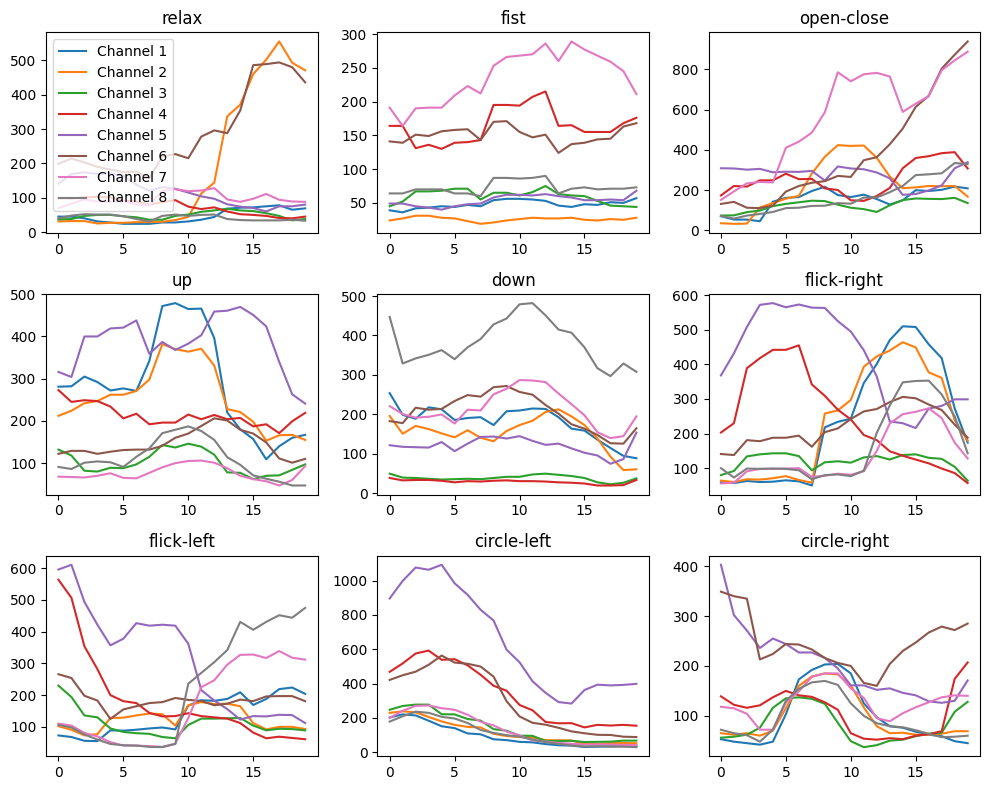

In [36]:
plt.figure(figsize=(10, 8))
ploti = 0
for gesturei in range(len(gestures)):
    ploti += 1
    plt.subplot(3, 3, ploti)
    sample_indices = np.where(Ttrain == gesturei)[0]
    plt.plot(Xtrain[sample_indices[0], :, :].T)
    plt.title(gestures[gesturei])
    if gesturei == 0:
        plt.legend([f'Channel {i}' for i in range(1, 9)])
plt.tight_layout()


# Requirement 2

As you did for the MNIST data, run some experiments with this EMG data. As before, answer questions about how helpful convolutional and fully-connected layers are.

Include plots of `nnet.pc_trace` and show confusion matrices.

In [37]:
Ttrain

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6.,
       6., 6., 6., 6., 6., 7., 7., 7., 7., 7., 7., 7., 7., 8., 8., 8., 8.,
       8., 8., 8., 8.])

In [100]:
# input variables for emg dataset
conv_specs = [(20, 2, 1), (20, 3, 2)]
fc_specs = [20]
input_shape = (8, 20)
n_outputs = 9
n_epochs = 20
batch_size = 2

method = 'adam'
learning_rate = 0.001

nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device=device)

nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')
confusion_matrix(nnet.use(Xtest), Ttest, range(9), 'Blues')

ConvNet: Using device cuda
adam Epoch 2 % Correct: Train 44.4 Val 33.3
adam Epoch 4 % Correct: Train 51.4 Val 38.9
adam Epoch 6 % Correct: Train 66.7 Val 44.4
adam Epoch 8 % Correct: Train 70.8 Val 41.7
adam Epoch 10 % Correct: Train 79.2 Val 47.2
adam Epoch 12 % Correct: Train 80.6 Val 48.6
adam Epoch 14 % Correct: Train 83.3 Val 51.4
adam Epoch 16 % Correct: Train 90.3 Val 50.0
adam Epoch 18 % Correct: Train 93.1 Val 50.0
adam Epoch 20 % Correct: Train 93.1 Val 48.6
% Correct: Train 83.3 Val 51.4 Test 65.3
Percent Correct (Actual class in rows, Predicted class in columns)


,0,1,2,3,4,5,6,7,8
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,12.5,12.5,25.0,0.0,37.5,0.0,0.0,12.5
3,0.0,0.0,0.0,75.0,0.0,12.5,0.0,12.5,0.0
4,0.0,0.0,0.0,0.0,87.5,0.0,0.0,12.5,0.0
5,0.0,0.0,0.0,25.0,12.5,62.5,0.0,0.0,0.0
6,0.0,0.0,0.0,12.5,0.0,0.0,37.5,25.0,25.0
7,12.5,0.0,0.0,0.0,0.0,50.0,0.0,37.5,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,75.0


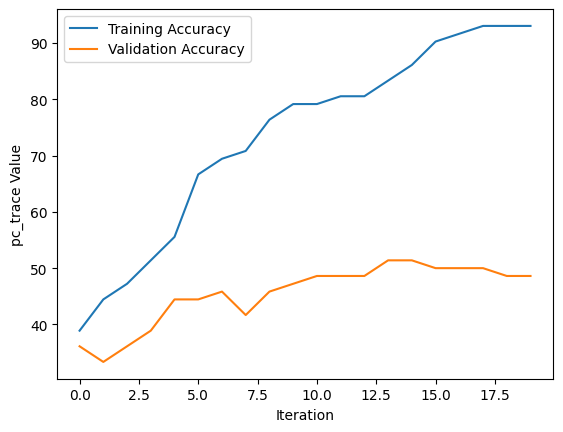

In [101]:
plt.plot(nnet.pc_trace, label=['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Iteration')
plt.ylabel('pc_trace Value')
plt.legend()
plt.show()

In [95]:
# experiment for emg dataset without conv layers
conv_specs = []
fc_specs = [20]
input_shape = (8, 20)
n_outputs = 9
n_epochs = 20
batch_size = 2

method = 'adam'
learning_rate = 0.001

nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device=device)

nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')
confusion_matrix(nnet.use(Xtest), Ttest, range(9), 'Blues')

ConvNet: Using device cuda
adam Epoch 2 % Correct: Train 59.7 Val 45.8
adam Epoch 4 % Correct: Train 66.7 Val 47.2
adam Epoch 6 % Correct: Train 73.6 Val 44.4
adam Epoch 8 % Correct: Train 77.8 Val 48.6
adam Epoch 10 % Correct: Train 81.9 Val 50.0
adam Epoch 12 % Correct: Train 87.5 Val 50.0
adam Epoch 14 % Correct: Train 88.9 Val 52.8
adam Epoch 16 % Correct: Train 90.3 Val 52.8
adam Epoch 18 % Correct: Train 90.3 Val 54.2
adam Epoch 20 % Correct: Train 93.1 Val 54.2
% Correct: Train 88.9 Val 54.2 Test 62.5
Percent Correct (Actual class in rows, Predicted class in columns)


,0,1,2,3,4,5,6,7,8
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,12.5,25.0,37.5,0.0,25.0,0.0,0.0,0.0
3,0.0,0.0,0.0,87.5,0.0,0.0,0.0,12.5,0.0
4,0.0,0.0,0.0,12.5,87.5,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,12.5,62.5,12.5,0.0,12.5
6,0.0,0.0,12.5,25.0,0.0,0.0,25.0,37.5,0.0
7,12.5,0.0,25.0,12.5,0.0,25.0,12.5,12.5,0.0
8,0.0,0.0,0.0,25.0,0.0,0.0,0.0,12.5,62.5


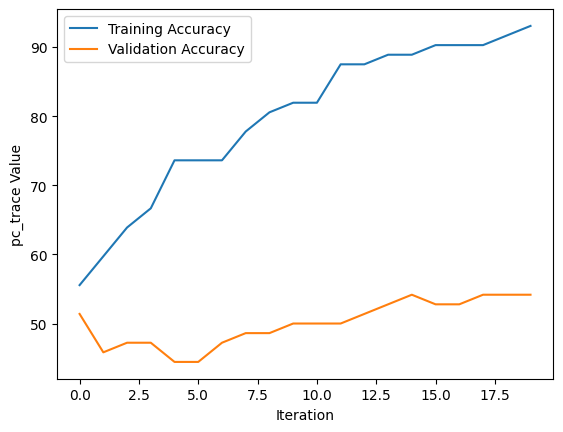

In [96]:
plt.plot(nnet.pc_trace, label=['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Iteration')
plt.ylabel('pc_trace Value')
plt.legend()
plt.show()

In [102]:
# experiment for emg dataset without fully connected layers
conv_specs = [(20, 2, 1), (20, 3, 2)]
fc_specs = []
input_shape = (8, 20)
n_outputs = 9
n_epochs = 20
batch_size = 2

method = 'adam'
learning_rate = 0.001

nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device=device)

nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')
confusion_matrix(nnet.use(Xtest), Ttest, range(9), 'Blues')

ConvNet: Using device cuda
adam Epoch 2 % Correct: Train 56.9 Val 47.2
adam Epoch 4 % Correct: Train 65.3 Val 45.8
adam Epoch 6 % Correct: Train 72.2 Val 48.6
adam Epoch 8 % Correct: Train 79.2 Val 51.4
adam Epoch 10 % Correct: Train 80.6 Val 48.6
adam Epoch 12 % Correct: Train 87.5 Val 54.2
adam Epoch 14 % Correct: Train 88.9 Val 54.2
adam Epoch 16 % Correct: Train 91.7 Val 54.2
adam Epoch 18 % Correct: Train 93.1 Val 52.8
adam Epoch 20 % Correct: Train 95.8 Val 52.8
% Correct: Train 87.5 Val 54.2 Test 56.9
Percent Correct (Actual class in rows, Predicted class in columns)


,0,1,2,3,4,5,6,7,8
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,12.5,25.0,50.0,0.0,12.5,0.0,0.0,0.0
3,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,12.5,87.5,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,37.5,12.5,37.5,0.0,12.5,0.0
6,0.0,0.0,0.0,25.0,0.0,0.0,12.5,50.0,12.5
7,12.5,0.0,0.0,25.0,0.0,37.5,12.5,0.0,12.5
8,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,50.0


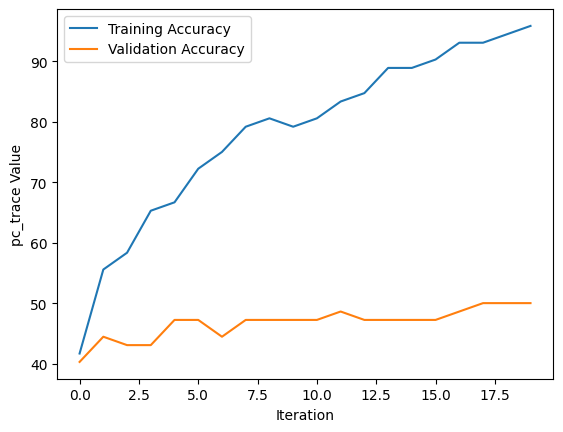

In [98]:
plt.plot(nnet.pc_trace, label=['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Iteration')
plt.ylabel('pc_trace Value')
plt.legend()
plt.show()

Discussion:

For the EMG dataset, I first tried to find the set of hyperparameters that provided a better performance. Initial experiment contained same set of hyperparameters as in the MNIST experiment, except for the batch size set to 10 to consider the total number of samples being 75. The training accuracy was 50% and test accuracy was 47.2%. Removing one of the convolutional layers and keeping only two of them increased the test accuracy to 52.8%. Then, for the second convolutional layer, the number of units was decreased from 20 to 10, which reduced the performance with test accuracy decreased to 48.6%. Then changing the number of units for first convolutional layer from 40 to 20 increased the training and validation accuracy by 12%. Higher number of units might have decreased the test accuracy due to over-fitting as it couln't generalize well for test data. But, keeping the units too few resulted in the model not being able to learn well enough. Thus, I settled for conv_specs to be [(20, 4, 1), (20, 3, 2)].

Then, fc_specs was increased from 10 to 20 and a increase in test accuracy was observed from 50% to 61.1%. Changing batch sizes also changed the accuracy, as when it was increased from 10 to 20, test accuracy decreased 52.8% whereas, decreasing it to 2, increased test accuracy to 66.7%. The lower value of batch size for the given sample size might have resulted in appropriate amount of updates to the weights in each epoch, giving a better performance.

Similarly, increasing epochs to 40, further decreased accuracy to 63.9% due to over-fitting, and decreasing patch size to 3 improved test accuracy with least amount of difference between training accuracy and test accuracy.


Then, experiments were performed without convolutional layers and without fully connected layers. With conv_specs = [], the test accuracy dropped from 69.4% to 58.3%, and also resulted in larger difference between the training accuracy and test accuracy. This means that the model performed worse in the absence of convolutional layers and overfitted with only fully connected layers.
Similarly, with fc_specs = [] the test accuracy decreased from 69.4% to 65.3% along with training accuracy increased to 91.7%. Without the fully connected layers, the performance got reduced and difference in training and test accuracy also increased due to overfitting. This means that the model wasn't able to generalize well in the absence of fully connected layers.

From the confusion matrices, it can be observed that the number of false classifications change significantly when the model's performance improves.
It can also be noticed that it was able to correctly classify classes such as 0,1, and 2 better than other classes and performs worse for classes like 6.

# Check In

Check in your jupyter notebook in Canvas.

There is no grading script provided for this assignment.  All grading will be done by running and reading your notebook.
50% of your grade will be based on your MNIST experiments and 50% on your EMG experiments.

# Extra Credit

Extra credit points will affect your semester grade in the following way.  Each extra credit point you have earned during the semester will add about half a point to your semester average grade, for a max of 3 semester average grade points.  So, if you have 6 extra credit points for the semester and your semester average is 77, your semester grade will be B-.  The maximum number of extra credit points will count for the semester is 8.

1. For the MNIST and EMG data, run experiments using the `relu` rather than `tanh` activation function.  Are the results similar or is one activation function better than the other?
1. Run your `ConvNet` on a different image data set with three channels, for red, green and blue pixel intensities.  You may download such data sets, then reduce the number of samples to be able to run some experiments with various parameter values.
2. Run your `ConvNet` on the accelerometer data we used in previous lectures.  This will have three channels, for accelerations in x, y and z.
3. Using either the MNIST or EMG data, or data from the above two extra credit steps, train an ensemble of at least 10 `ConvNet`s on the data and compare the results you get for just one `ConvNet`.

1. For the MNIST and EMG data, run experiments using the relu rather than tanh activation function. Are the results similar or is one activation function better than the other?

ConvNet: Using device cuda
adam Epoch 2 % Correct: Train 88.8 Val 90.1
adam Epoch 4 % Correct: Train 93.1 Val 94.0
adam Epoch 6 % Correct: Train 95.1 Val 95.7
adam Epoch 8 % Correct: Train 96.4 Val 96.7
adam Epoch 10 % Correct: Train 97.0 Val 97.0
adam Epoch 12 % Correct: Train 97.5 Val 97.5
adam Epoch 14 % Correct: Train 97.8 Val 97.6
adam Epoch 16 % Correct: Train 98.0 Val 97.8
adam Epoch 18 % Correct: Train 98.3 Val 97.8
adam Epoch 20 % Correct: Train 98.5 Val 97.9
% Correct: Train 98.5 Val 97.9 Test 98.1
Percent Correct (Actual class in rows, Predicted class in columns)


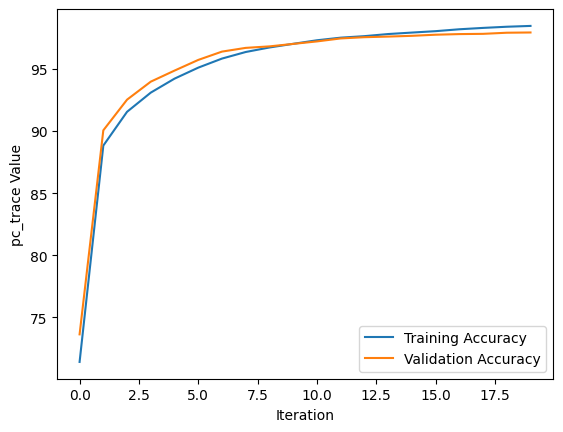

In [84]:
# experiment for MNIST using relu
with gzip.open('mnist.pkl.gz', 'rb') as f:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1]
Xval = valid_set[0]
Tval = valid_set[1]
Xtest = test_set[0]
Ttest = test_set[1]

conv_specs = [(40, 4, 1), (20, 3, 2), (20, 3, 2)]
fc_specs = [20]
input_shape = (1, 28, 28)
n_outputs = 10
n_epochs = 20
batch_size = 2000
method = 'adam'
learning_rate = 0.001

nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='relu', device=device)

nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')
confusion_matrix(nnet.use(Xtest), Ttest, range(10), 'Blues')
plt.plot(nnet.pc_trace, label=['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Iteration')
plt.ylabel('pc_trace Value')
plt.legend()
plt.show()

ConvNet: Using device cuda
adam Epoch 2 % Correct: Train 25.0 Val 19.4
adam Epoch 4 % Correct: Train 30.6 Val 25.0
adam Epoch 6 % Correct: Train 43.1 Val 33.3
adam Epoch 8 % Correct: Train 52.8 Val 34.7
adam Epoch 10 % Correct: Train 58.3 Val 37.5
adam Epoch 12 % Correct: Train 70.8 Val 37.5
adam Epoch 14 % Correct: Train 76.4 Val 40.3
adam Epoch 16 % Correct: Train 81.9 Val 41.7
adam Epoch 18 % Correct: Train 86.1 Val 43.1
adam Epoch 20 % Correct: Train 91.7 Val 48.6
% Correct: Train 91.7 Val 48.6 Test 62.5
Percent Correct (Actual class in rows, Predicted class in columns)


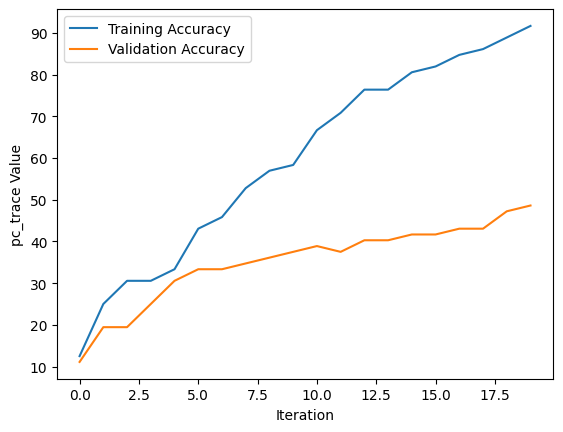

In [85]:
# experiment for EMG Data using Relu
gestures = ['relax','fist','open-close','up','down','flick-right',
            'flick-left','circle-left','circle-right']

dict = np.load('emg.npz')
Xtrain = dict['Xtrain']
Ttrain = dict['Ttrain']
Xval = dict['Xval']
Tval = dict['Tval']
Xtest = dict['Xtest']
Ttest = dict['Ttest']

conv_specs = [(20, 2, 1), (20, 3, 2)]
fc_specs = [20]
input_shape = (8, 20)
n_outputs = 9
n_epochs = 20
batch_size = 2

method = 'adam'
learning_rate = 0.001

nnet = ConvNet(input_shape, conv_specs, fc_specs, n_outputs, activation_function='relu', device=device)

nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method, learning_rate)

pc_train = nnet.percent_correct(nnet.use(Xtrain), Ttrain)
pc_val = nnet.percent_correct(nnet.use(Xval), Tval)
pc_test = nnet.percent_correct(nnet.use(Xtest), Ttest)

print(f'% Correct: Train {pc_train:.1f} Val {pc_val:.1f} Test {pc_test:.1f}')
confusion_matrix(nnet.use(Xtest), Ttest, range(9), 'Blues')


plt.plot(nnet.pc_trace, label=['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Iteration')
plt.ylabel('pc_trace Value')
plt.legend()
plt.show()

Discussion for Extra Credit 1:

It can be observed that changing the activation function from tanh to relu improved the accuracy for MNSIT data to 98.1% and to 62.5% for EMG dataset.
This mean Relu can help increase performance more than tanh activation.